<a href="https://colab.research.google.com/github/AndresPerelmuter/Clustering/blob/main/Cluster_H%26M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objetivo**

---



# **Exploracion de los Datos**

---




In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import pairwise_distances_argmin_min
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to compute distances
from scipy.spatial.distance import pdist, cdist

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings("ignore")


ModuleNotFoundError: ignored

In [140]:
pip install pyclustertend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
transactions = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
articles = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/customers.csv")


**Transactions**

In [79]:
transactions.head(5)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [80]:
transactions.shape

(31788324, 5)

In [81]:
transactions.describe()

,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e-02,1.704028e+00
std,1.334480e+08,1.918113e-02,4.564786e-01
min,1.087750e+08,1.694915e-05,1.000000e+00
25%,6.328030e+08,1.581356e-02,1.000000e+00
50%,7.145820e+08,2.540678e-02,2.000000e+00
75%,7.865240e+08,3.388136e-02,2.000000e+00
max,9.562170e+08,5.915254e-01,2.000000e+00


In [82]:
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [83]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [84]:
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

**Customers**

In [85]:
customers.head(5)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [86]:
customers.shape

(1371980, 7)

In [87]:
customers.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


In [88]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [89]:
customers.dtypes

customer_id                object
FN                        float64
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

**Articles**

In [90]:
articles.head(5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [91]:
articles.shape

(105542, 25)

In [92]:
articles.describe()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
count,1.055420e+05,105542.000000,105542.000000,1.055420e+05,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000
mean,6.984246e+08,698424.563378,234.861875,1.009515e+06,32.233822,3.206183,7.807972,4532.777833,3.171534,42.664219,1010.438290
std,1.284624e+08,128462.384432,75.049308,2.241359e+04,28.086154,1.563839,5.376727,2712.692011,4.353234,23.260105,6.731023
min,1.087750e+08,108775.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,1201.000000,1.000000,2.000000,1001.000000
25%,6.169925e+08,616992.500000,252.000000,1.010008e+06,9.000000,2.000000,4.000000,1676.000000,1.000000,20.000000,1005.000000
50%,7.022130e+08,702213.000000,259.000000,1.010016e+06,14.000000,4.000000,5.000000,4222.000000,2.000000,46.000000,1009.000000
75%,7.967030e+08,796703.000000,272.000000,1.010016e+06,52.000000,4.000000,11.000000,7389.000000,4.000000,61.000000,1017.000000
max,9.594610e+08,959461.000000,762.000000,1.010029e+06,93.000000,7.000000,20.000000,9989.000000,26.000000,97.000000,1025.000000


In [93]:
articles.dtypes

article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

### **Preparación de los Datos**

---



In [94]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [106]:
def outliers(df):
    for col in df.columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.1,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]

**Transactions**

In [96]:
missing_zero_values_table(transactions)

Your selected dataframe has 5 columns and 31788324 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [97]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

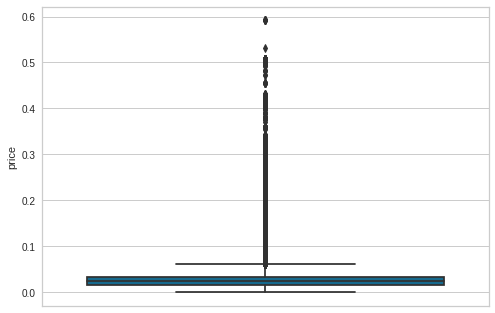

In [98]:
sns.boxplot(y = transactions['price'])

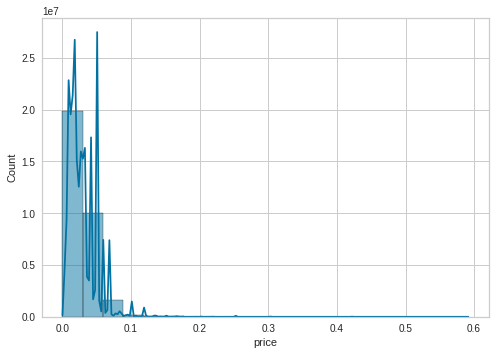

In [99]:
sns.histplot(data=transactions, x="price", palette='winter', bins=20, kde=True)

In [109]:
outliers(transactions)

**Customers**

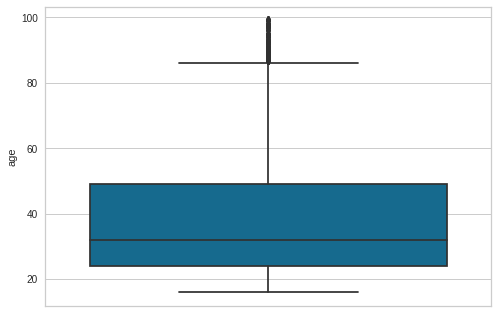

In [100]:
sns.boxplot(y = customers['age'])

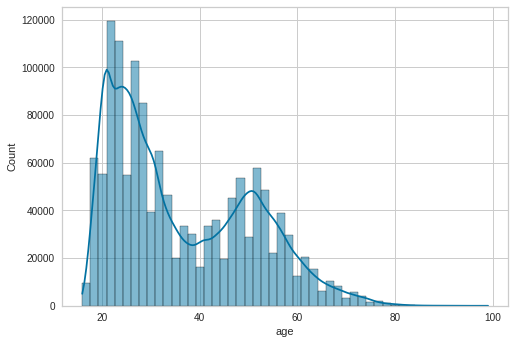

In [101]:
sns.histplot(data=customers, x="age", palette='winter', bins=50, kde=True)

In [53]:
Q1=customers['age'].quantile(0.25)
Q3=customers['age'].quantile(0.75)
IQR=Q3-Q1
# Upper bound
upper = Q3+1.5*IQR
# Lower bound
lower = Q1-1.5*IQR
''' Removing the Outliers '''

customers['age']= [x for x in customers['age'] if x >= lower and x <= upper]
#customers['age'] = (customers['age']>lower) | (customers['age']<upper)
#customers['age'] = customers['age'].drop(upper[0], inplace = True)
#customers['age'] = customers['age'].drop(lower[0], inplace = True)

ValueError: ignored

In [64]:
# calculate interquartile range
Q1=customers['age'].quantile(0.25)
Q3=customers['age'].quantile(0.75)
IQR=Q3-Q1
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (Q1, Q3, IQR))
# calculate the outlier cutoff
cut_off = IQR * 1.5
lower, upper = Q1 - cut_off, Q3 + cut_off
# identify outliers
outliers = [x for x in customers['age] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in customers['age'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

SyntaxError: ignored

In [102]:
missing_zero_values_table(customers)

Your selected dataframe has 7 columns and 1371980 Rows.
There are 5 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Active,0,907576,66.2,907576,66.2,float64
FN,0,895050,65.2,895050,65.2,float64
fashion_news_frequency,0,16009,1.2,16009,1.2,object
age,0,15861,1.2,15861,1.2,float64
club_member_status,0,6062,0.4,6062,0.4,object


In [103]:
customers = customers.drop(['Active', 'FN'], axis=1)
customers = customers.dropna()

In [107]:
outliers(customers)

**Articles**

In [104]:
missing_zero_values_table(articles)

Your selected dataframe has 25 columns and 105542 Rows.
There are 1 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
detail_desc,0,416,0.4,416,0.4,object


In [108]:
outliers(articles)

**Creación Variables**

In [110]:
df = transactions.groupby('customer_id').agg(
    precio_promedio=('price', 'mean'),
    compras_totales=('price', sum),
    cantidad_compras=('price', 'count'),
    # Get max of the duration column for each group
    fecha_ultima_compra=('t_dat', max),
    # Get min of the duration column for each group
    fecha_primer_compra=('t_dat', min),
    # Apply a lambda to date column
    antiguedad=("t_dat", lambda x: (max(x) - min(x)).days)   
)

In [112]:
df['promedio_dias_compra'] = transactions['previous_visit'] = transactions.groupby(['customer_id'])['t_dat'].shift()
df['promedio_dias_compra'] = transactions['days_bw_visits'] = transactions['t_dat'] - transactions['previous_visit']
df['promedio_dias_compra'] = transactions['days_bw_visits'] = transactions['days_bw_visits'].apply(lambda x: x.days)
df['promedio_dias_compra'] = transactions.groupby('customer_id')['days_bw_visits'].agg('mean')

df = pd.merge(df, customers[['customer_id','age']], on="customer_id")
df.fillna(axis=1, method="bfill").fillna(0)


,customer_id,precio_promedio,compras_totales,cantidad_compras,fecha_ultima_compra,fecha_primer_compra,antiguedad,promedio_dias_compra,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.030904,0.648983,21,2020-09-05,2018-12-27,618,30.900000,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.030351,2.610203,86,2020-07-08,2018-09-21,656,7.717647,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.039154,0.704780,18,2020-09-15,2018-09-20,726,42.705882,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.030492,0.060983,2,2019-06-09,2019-06-09,0,0.000000,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.036130,0.469695,13,2020-08-12,2018-10-12,670,55.833333,52.0
...,...,...,...,...,...,...,...,...,...
1328982,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.025503,1.300678,51,2020-09-06,2019-04-03,522,10.440000,24.0
1328983,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.022081,1.854780,84,2020-08-18,2018-09-25,693,8.349398,21.0
1328984,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0.018214,0.819627,45,2020-09-09,2018-09-20,720,16.363636,21.0
1328985,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0.029886,0.209203,7,2020-06-22,2020-04-05,78,13.000000,21.0


In [ ]:
#eliminar
#df['precio_promedio'] = df['precio_promedio'].astype(int)
#df['compras_totales'] = df['compras_totales'].astype(int)
#df['promedio_dias_compra'] = df['promedio_dias_compra'].astype(int)

In [113]:
#df1 = pd.merge(customers[['customer_id']], transactions[['customer_id', 'sales_channel_id']], on="customer_id")
df6 = transactions[['customer_id','sales_channel_id']]

In [114]:
df6 = df6.pivot_table(index='customer_id', columns='sales_channel_id', aggfunc=len, fill_value=0)
df6 = pd.DataFrame(df6)
df6.rename(columns={'1': 'Sales Store', '2': 'Sales Online'}, inplace=True)

In [115]:
temp = pd.merge(transactions[["customer_id", "article_id"]], articles[['article_id','index_group_name']], on="article_id", how='inner')
temp = temp.dropna()
ca_matrix = pd.crosstab(index=temp.customer_id, columns=temp.index_group_name)
ca_matrix = pd.DataFrame(ca_matrix)

In [116]:
df8 = pd.merge(ca_matrix, df, on='customer_id')
df8 = pd.merge(df8, df6, on='customer_id')
df8


,customer_id,Baby/Children,Divided,Ladieswear,Menswear,Sport,precio_promedio,compras_totales,cantidad_compras,fecha_ultima_compra,fecha_primer_compra,antiguedad,promedio_dias_compra,age,1,2
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,5,2,13,0,0,0.030904,0.648983,21,2020-09-05,2018-12-27,618,30.900000,49.0,9,12
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,4,17,58,0,1,0.030351,2.610203,86,2020-07-08,2018-09-21,656,7.717647,25.0,5,81
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,1,9,4,1,0.039154,0.704780,18,2020-09-15,2018-09-20,726,42.705882,24.0,0,18
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,2,0.030492,0.060983,2,2019-06-09,2019-06-09,0,0.000000,54.0,0,2
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0,0,9,0,2,0.036130,0.469695,13,2020-08-12,2018-10-12,670,55.833333,52.0,2,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304800,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0,0,44,1,4,0.025503,1.300678,51,2020-09-06,2019-04-03,522,10.440000,24.0,13,38
1304801,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,7,48,25,2,0,0.022081,1.854780,84,2020-08-18,2018-09-25,693,8.349398,21.0,28,56
1304802,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0,16,16,4,1,0.018214,0.819627,45,2020-09-09,2018-09-20,720,16.363636,21.0,11,34
1304803,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0,4,3,0,0,0.029886,0.209203,7,2020-06-22,2020-04-05,78,13.000000,21.0,1,6


In [117]:
# selecting numerical columns
num_cols = df8.select_dtypes(include=np.number).columns.tolist()

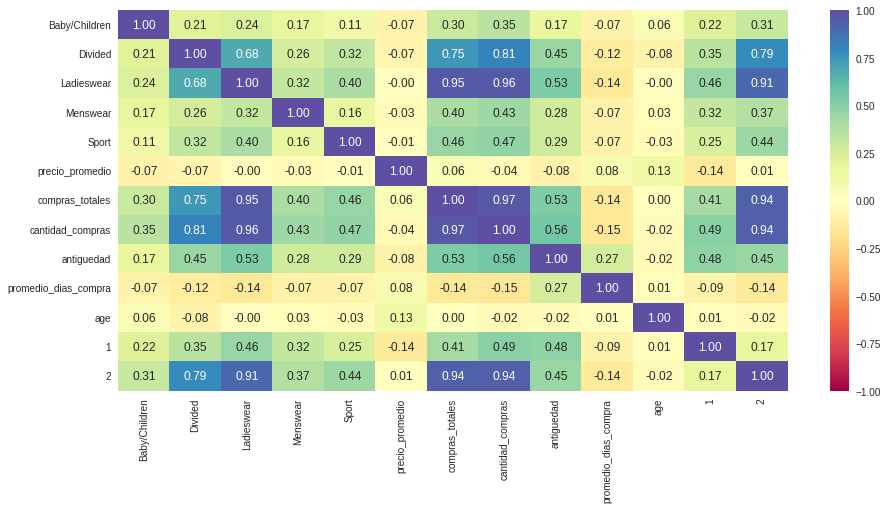

In [118]:
# check for correlations

plt.figure(figsize=(15, 7))
sns.heatmap(
    df8[num_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

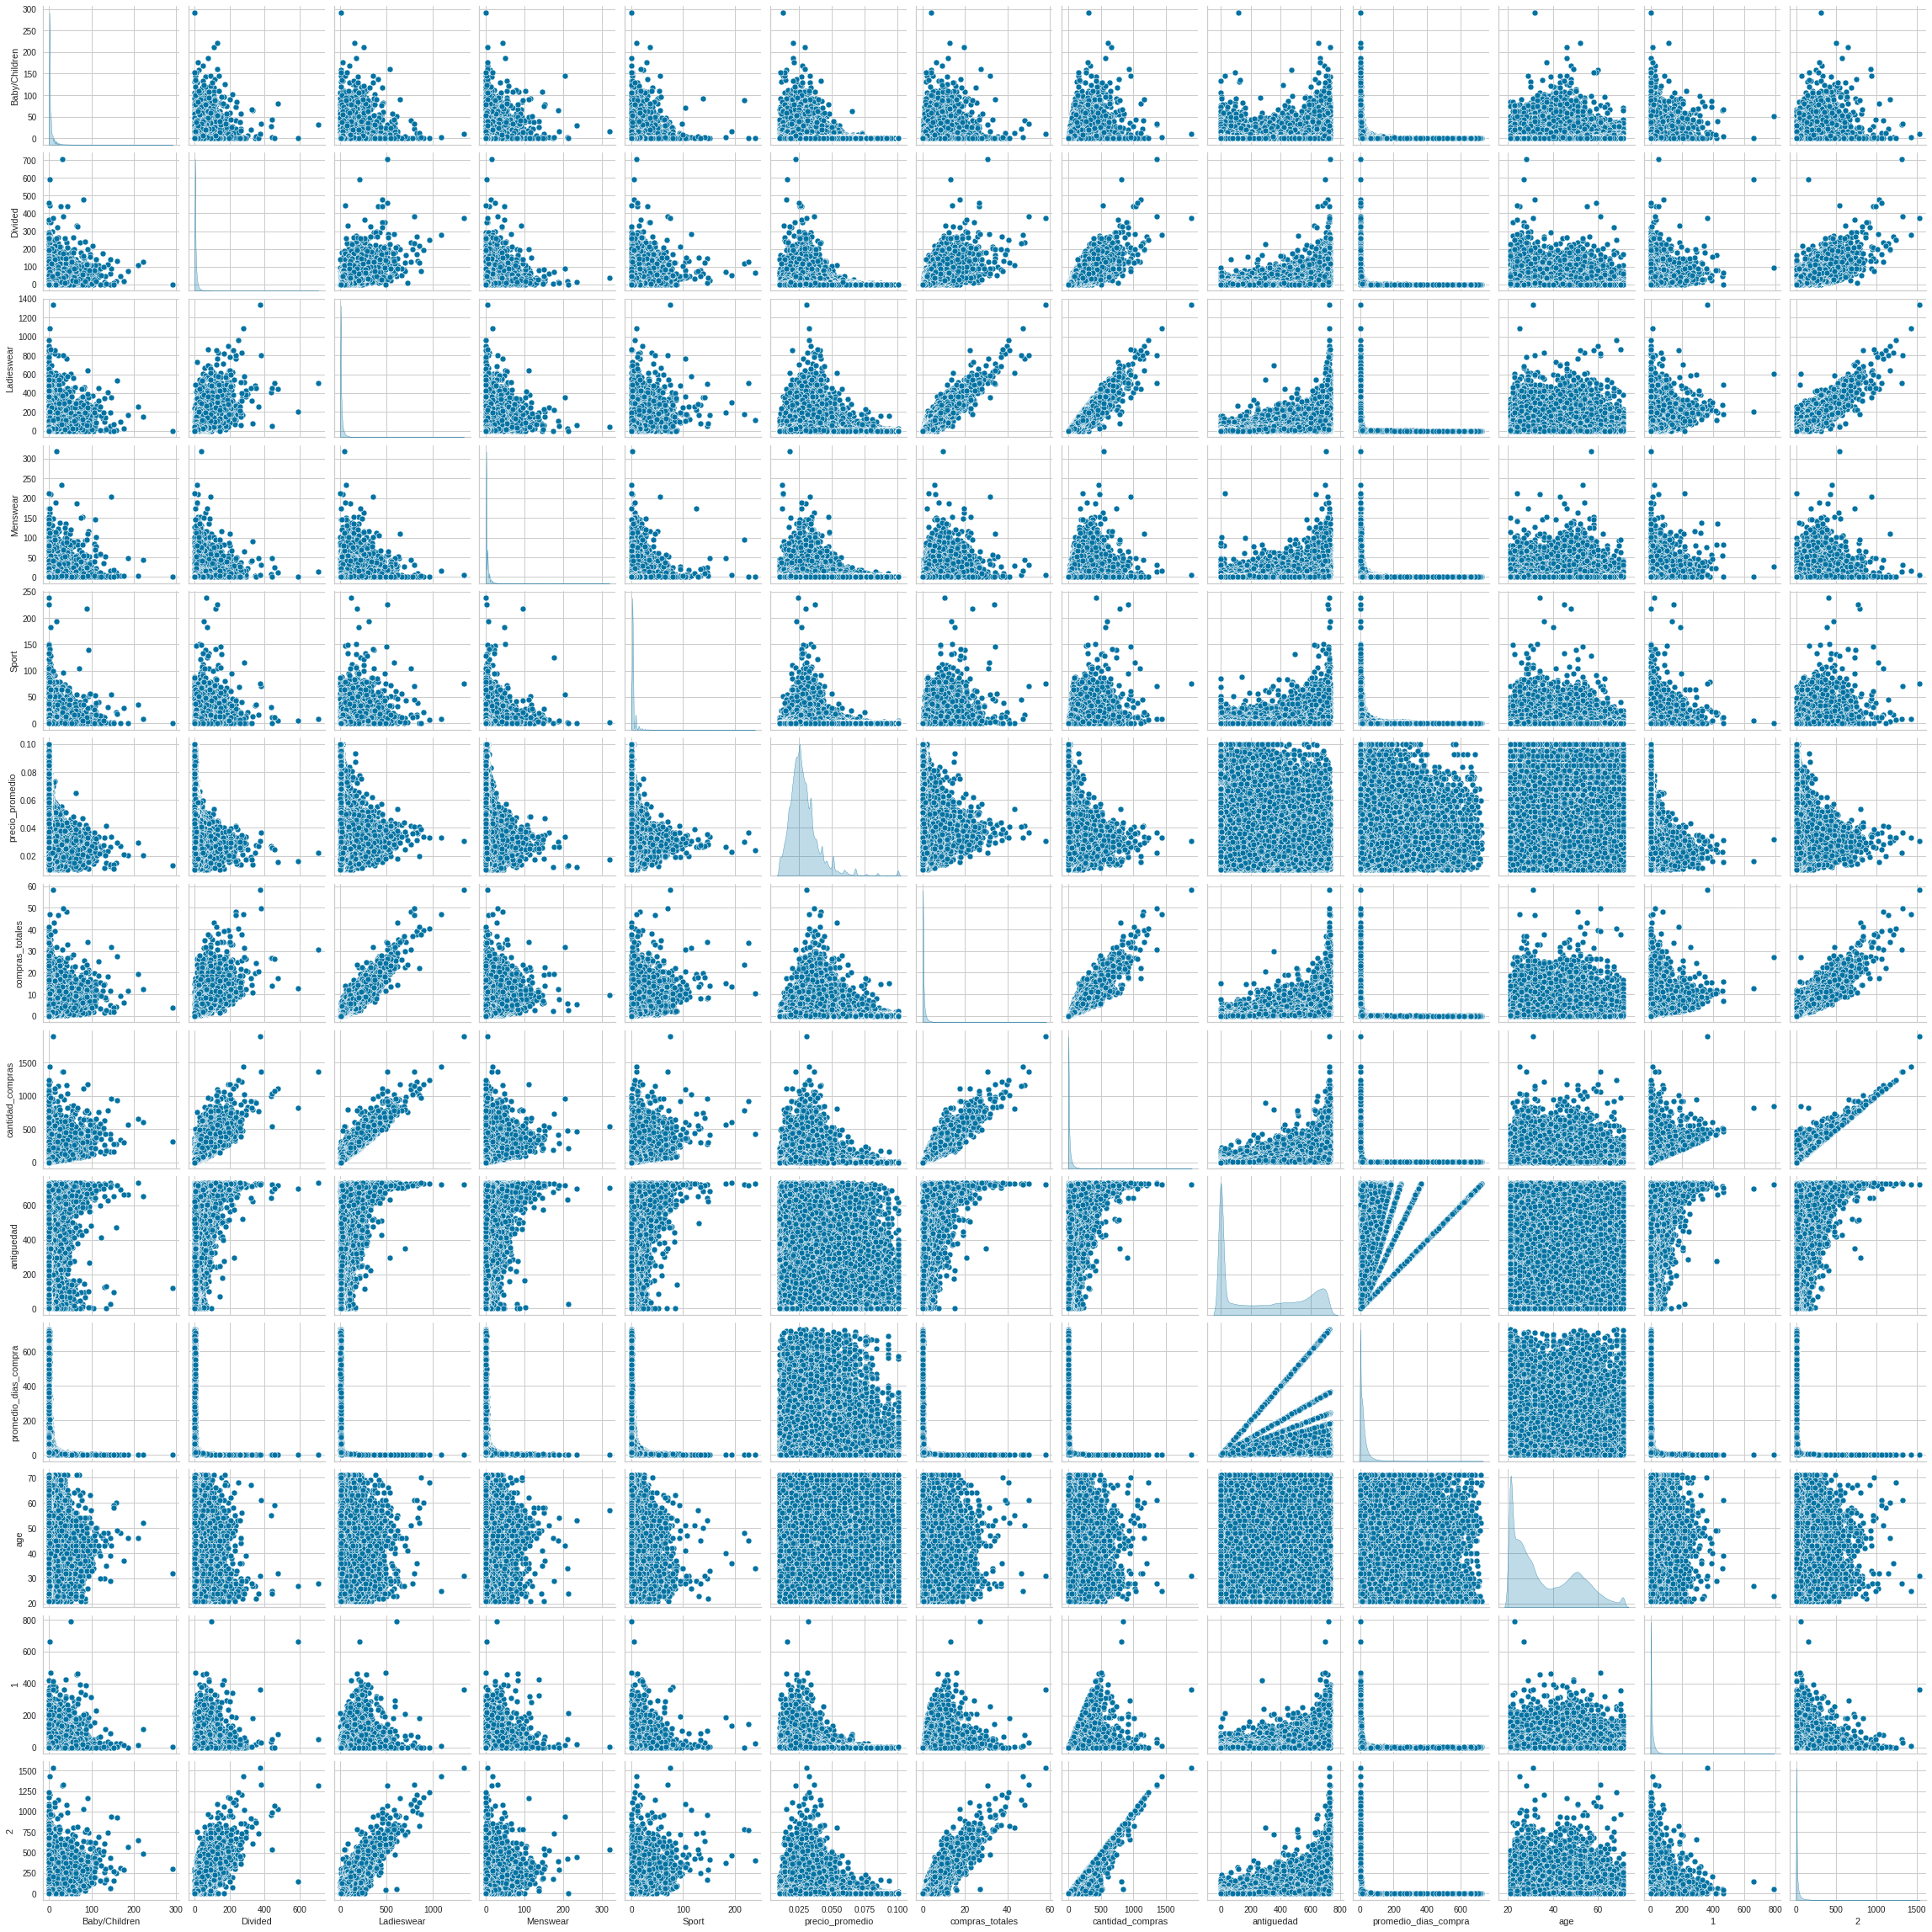

In [119]:
sns.pairplot(df8[num_cols],diag_kind="kde")

In [ ]:
df8 = pd.merge(customers, transactions, on='customer_id')

In [48]:
df8 = df8.dropna()

In [ ]:
df6.columns

MultiIndex([('t_dat', 1),
            ('t_dat', 2)],
           names=[None, 'sales_channel_id'])

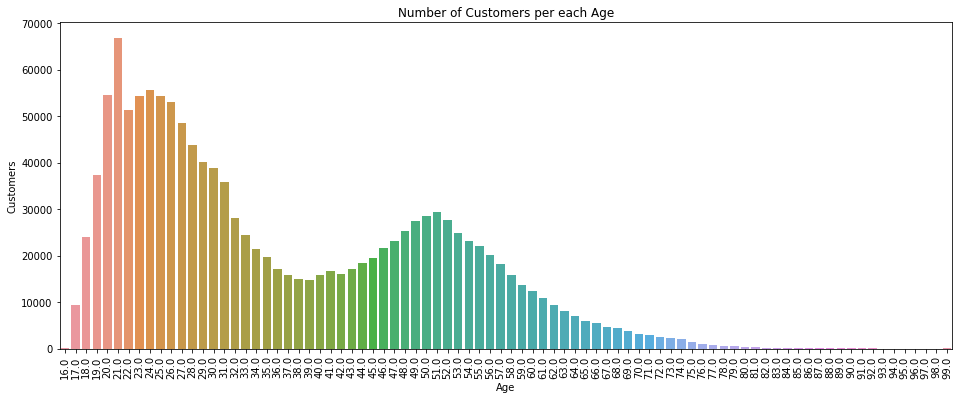

In [ ]:
temp = customers.groupby(["age"])["customer_id"].count()
df = pd.DataFrame({'Age': temp.index,
                   'Customers': temp.values
                  })
df = df.sort_values(['Age'], ascending=False)
plt.figure(figsize = (16,6))
plt.title(f'Number of Customers per each Age')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'Age', y="Customers", data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

ValueError: ignored

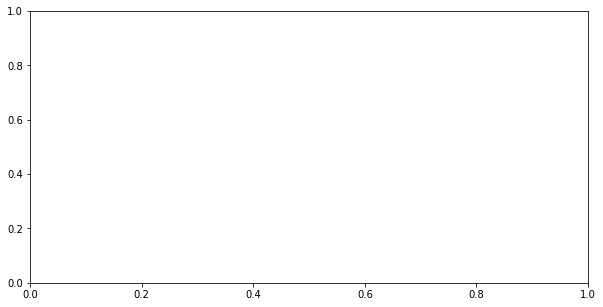

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=df8, x='age', bins=df8['age'].nunique(), hue='sales_channel_id')
ax.set_xlabel('Distribution of the customers age')
for loc in ['bottom', 'left']:
    ax.spines[loc].set_visible(True)
    ax.spines[loc].set_linewidth(2)
    ax.spines[loc].set_color('black')
plt.show()

# **Modelado**

---



In [120]:
dfcluster = df8[num_cols]
dfcluster = dfcluster.dropna()

In [121]:
scaler = StandardScaler()
dfcluster = scaler.fit_transform(dfcluster)

In [141]:
from pyclustertend import hopkins
hopkins(dfcluster,150)

0.005083752440970677

In [42]:
# k means determine k
distortions = []
K = range(3,12)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(dfcluster)
    kmeanModel.fit(dfcluster)
    distortions.append(sum(np.min(cdist(dfcluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / dfcluster.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

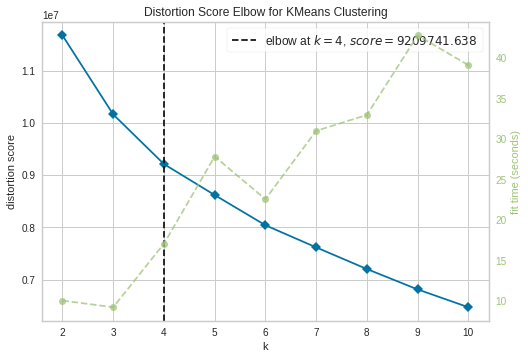

In [124]:
kmeanModel = KMeans()
elb_visualizer = KElbowVisualizer(kmeanModel, k=(2,11))
elb_visualizer.fit(dfcluster)    
elb_visualizer.show() 

In [ ]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state = 1))
visualizer.fit(dfcluster)    
visualizer.show()

KeyboardInterrupt: ignored

In [ ]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer7 = SilhouetteVisualizer(KMeans(7, random_state = 1))
visualizer7.fit(dfcluster)    
visualizer7.show();

In [ ]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer8 = SilhouetteVisualizer(KMeans(8, random_state = 1))
visualizer8.fit(dfcluster)    
visualizer8.show();

In [ ]:
dfcluster

array([[ 1.01060403, -0.33753224, -0.1316445 , ...,  0.23528022,
         0.09522942, -0.17269172],
       [ 0.75876721,  1.16629186,  1.63486721, ..., -0.36083789,
        -0.19152429,  1.73646439],
       [-0.24858003, -0.42599248, -0.16769576, ...,  0.5388603 ,
        -0.54996641, -0.00667815],
       ...,
       [ 1.51427765,  3.73163885,  0.37307313, ..., -0.34459287,
         1.4573095 ,  1.04474116],
       [-0.24858003,  1.07783162,  0.08466306, ..., -0.13851228,
         0.23860627,  0.43602472],
       [-0.24858003, -0.16061175, -0.49215709, ..., -0.22500585,
        -0.47827799, -0.3387053 ]])

In [ ]:
dfcluster = pd.DataFrame(dfcluster)

In [125]:
# Para el ejercicio, elijo 5 como un buen valor de K. Pero podría ser otro.
kmeans = KMeans(n_clusters=4).fit(dfcluster)
predict=kmeans.predict(dfcluster)
#dfcluster['Pred'] = kmeans.predict

In [127]:
df8 = df8.dropna()

df8["Cluster"] = kmeans.labels_
df8.head()

,customer_id,Baby/Children,Divided,Ladieswear,Menswear,Sport,precio_promedio,compras_totales,cantidad_compras,fecha_ultima_compra,fecha_primer_compra,antiguedad,promedio_dias_compra,age,1,2,Cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,5,2,13,0,0,0.030904,0.648983,21,2020-09-05,2018-12-27,618,30.900000,49.0,9,12,1
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,4,17,58,0,1,0.030351,2.610203,86,2020-07-08,2018-09-21,656,7.717647,25.0,5,81,2
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,1,9,4,1,0.039154,0.704780,18,2020-09-15,2018-09-20,726,42.705882,24.0,0,18,1
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,2,0.030492,0.060983,2,2019-06-09,2019-06-09,0,0.000000,54.0,0,2,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0,0,9,0,2,0.036130,0.469695,13,2020-08-12,2018-10-12,670,55.833333,52.0,2,11,1


In [134]:
results = df8.groupby('Cluster').agg(
    precio_promedio=('precio_promedio', 'mean'),
    compras_totales=('compras_totales', 'mean'),
    antiguedad=('antiguedad', 'max'),
    fecha_ultima_compra=('compras_totales', 'mean'),
    promedio_dias_compras=('promedio_dias_compra', 'mean'),  
    age=('age', 'mean'),
    store=(1, 'mean'),
    online=(2, 'mean'),
    baby_children=('Baby/Children', 'mean'),
    Ladieswear	=('Ladieswear', 'mean'),  
    Menswear=('Menswear', 'mean'),
    Sport=('Sport', 'mean'),       
)

In [135]:
results

,precio_promedio,compras_totales,antiguedad,fecha_ultima_compra,promedio_dias_compras,age,store,online,baby_children,Ladieswear,Menswear,Sport
Cluster,,,,,,,,,,,,
0,0.027819,0.195360,329,0.195360,7.112235,36.658512,2.045306,5.200459,0.451824,4.072639,0.328939,0.251193
1,0.027579,0.563620,733,0.563620,45.011833,36.131209,8.107393,12.758232,0.529620,12.256243,0.935846,0.762274
2,0.027657,2.211193,733,2.211193,8.787047,36.051278,23.948450,55.632277,2.538598,46.555707,4.246801,3.074045
3,0.030274,7.107163,733,7.107163,3.184066,36.581887,25.950521,209.622444,7.953607,142.895978,9.648196,8.507861


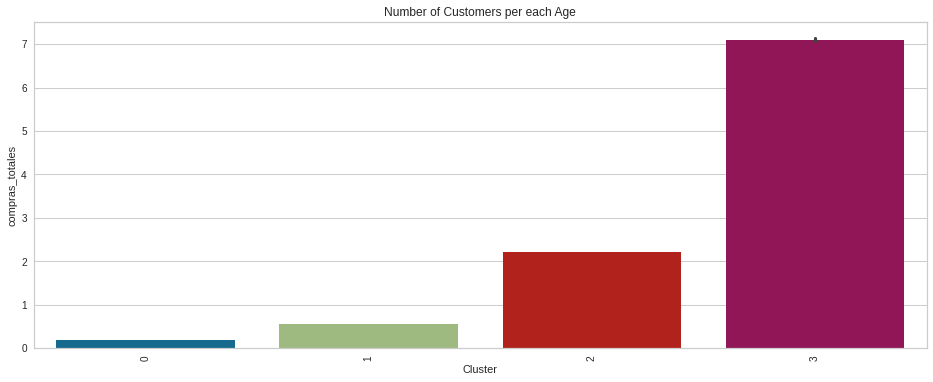

In [139]:
plt.figure(figsize = (16,6))
plt.title(f'Number of Customers per each Age')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'Cluster', y="compras_totales", data=df8)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

In [ ]:
plt.figure(figsize = (16,6))
plt.title(f'Number of Customers per each Age')
sns.set_color_codes("pastel")
s = sns.barplot(x = '', y="compras_totales", data=df8)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

In [ ]:
dfcluster['pred'] = kmeans.labels_

In [ ]:
dfcluster

,0,1,2,3,4,5,6,7,8,9,10,11,pred
0,1.010604,-0.337532,-0.131644,-0.096478,-0.325521,0.269730,-0.056918,-0.120591,1.168483,0.235280,0.095229,-0.172692,2
1,0.758767,1.166292,1.634867,-0.314331,-0.005070,0.214384,1.508110,1.474857,1.310190,-0.360838,-0.191524,1.736464,3
2,-0.248580,-0.425992,-0.167696,0.557080,-0.005070,0.973396,-0.012205,-0.194227,1.571231,0.538860,-0.549966,-0.006678,2
3,-0.248580,-0.514453,-0.600311,-0.314331,0.315381,0.234554,-0.528122,-0.586952,-1.136131,-0.559292,-0.549966,-0.449381,0
4,-0.248580,-0.514453,-0.203747,-0.314331,0.315381,0.715481,-0.200594,-0.316954,1.362399,0.876424,-0.406590,-0.200361,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214414,-0.248580,-0.249072,-0.600311,-0.314331,-0.325521,0.138666,-0.506390,-0.562407,-1.136131,-0.559292,-0.334901,-0.504719,0
1214415,-0.248580,-0.514453,1.058047,-0.096478,0.956282,-0.204782,0.458659,0.615770,0.810485,-0.290834,0.381983,0.546700,2
1214416,1.514278,3.731639,0.373073,0.121375,-0.325521,-0.530972,0.871336,1.425766,1.448169,-0.344593,1.457310,1.044741,3
1214417,-0.248580,1.077832,0.084663,0.774933,0.635831,-0.870752,0.055232,0.468498,1.548856,-0.138512,0.238606,0.436025,2


In [ ]:
# Para el ejercicio, elijo 5 como un buen valor de K. Pero podría ser otro.
kmeans = KMeans(n_clusters=4).fit(dfcluster)
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.09878517 -0.09717146 -0.10716818 -0.07457145 -0.06770507 -0.01625217
  -0.12639866 -0.12314349  0.70478637  0.60102528  0.03347597 -0.15173484]
 [-0.12107366 -0.37586861 -0.44156297 -0.23002641 -0.24196665  0.00745832
  -0.42361441 -0.46118095 -0.95803906 -0.37842633 -0.40597606 -0.36317881]
 [ 1.97477646  4.29631927  4.89259996  2.14661266  2.59586598  0.23492359
   5.16589005  5.15638325  1.38903423 -0.47757985  1.30979885  5.30704068]
 [ 0.46007282  1.059049    1.24383132  0.7536685   0.71843948 -0.00963795
   1.2007445   1.32550142  1.17765328 -0.334287    1.1718399   1.04189707]]


In [ ]:
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.09878517 -0.09717146 -0.10716818 -0.07457145 -0.06770507 -0.01625217
  -0.12639866 -0.12314349  0.70478637  0.60102528  0.03347597 -0.15173484]
 [-0.12107366 -0.37586861 -0.44156297 -0.23002641 -0.24196665  0.00745832
  -0.42361441 -0.46118095 -0.95803906 -0.37842633 -0.40597606 -0.36317881]
 [ 1.97477646  4.29631927  4.89259996  2.14661266  2.59586598  0.23492359
   5.16589005  5.15638325  1.38903423 -0.47757985  1.30979885  5.30704068]
 [ 0.46007282  1.059049    1.24383132  0.7536685   0.71843948 -0.00963795
   1.2007445   1.32550142  1.17765328 -0.334287    1.1718399   1.04189707]]


In [ ]:
from collections import Counter
Counter(kmeans.labels_)


Counter({0: 463887, 3: 160971, 1: 568900, 2: 20661})

In [ ]:
clusters = pd.DataFrame(kmeans.labels_)
clusters

,0
0,0
1,3
2,0
3,1
4,0
...,...
1214414,1
1214415,0
1214416,3
1214417,0


In [ ]:
cluster_profile = df.groupby('K_means_segments').mean()

In [ ]:
# Obtenemos las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X)
# Obtenemos los centroids
C = kmeans.cluster_centers_
colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [ ]:
#articles['article_id'] = articles['article_id'].astype(str)
articles['index_group_no'] = articles['index_group_no'].astype(str)
#transactions['article_id'] = transactions['article_id'].astype(str)

In [ ]:
temp = pd.merge(transactions[["customer_id", "article_id"]], articles[['article_id','index_group_no']], on="article_id", how='inner')

# check null values and drop it.
display(temp[temp.isnull().any(axis=1)])

temp = temp.dropna()

ca_matrix = pd.crosstab(index=temp.customer_id, columns=temp.index_group_no)
ca_matrix

,customer_id,article_id,index_group_no


index_group_no,1,2,3,4,26
customer_id,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,13,2,1,5,0
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,62,19,0,4,1
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,12,1,4,0,1
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0,0,0,0,2
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,11,0,0,0,2
...,...,...,...,...,...
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,46,0,1,0,4
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,27,48,2,7,0
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264,19,18,5,0,3


In [ ]:
temp

,t_dat,customer_id,article_id,price,sales_channel_id,index_group_no
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0 663713001\n1 541518023\n...,0.050831,2.0,NaN
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0 663713001\n1 541518023\n...,0.030492,2.0,NaN
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0 663713001\n1 541518023\n...,0.015237,2.0,NaN
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0 663713001\n1 541518023\n...,0.016932,2.0,NaN
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0 663713001\n1 541518023\n...,0.016932,2.0,NaN
...,...,...,...,...,...,...
31893861,NaT,NaN,953450001,NaN,NaN,3
31893862,NaT,NaN,953763001,NaN,NaN,1
31893863,NaT,NaN,956217002,NaN,NaN,1
31893864,NaT,NaN,957375001,NaN,NaN,2


In [ ]:
temp.dtypes

article_id             object
price                 float64
prod_name              object
product_type_name      object
product_group_name     object
department_name        object
index_name             object
index_group_name       object
section_name           object
garment_group_name     object
customer_id            object
age                   float64
dtype: object

In [ ]:
transactions = transactions[["customer_id", "article_id", "price"]]
customers = customers[["customer_id", "age"]]
articles = articles[["article_id", "prod_name", "product_type_name", "product_group_name",
                     "department_name", "index_name", "index_group_name",
                     "section_name", "garment_group_name"]]



In [ ]:
temp = pd.merge(transactions, articles, on="article_id", how='inner')
temp = pd.merge(temp, customers, on="customer_id", how='inner')
temp

,article_id,price,prod_name,product_type_name,product_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,customer_id,age


# **Conclusión**

---

